In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from GeoDySys import plotting, geometry, utils, net
from DE_library import simulate_ODE
import pyEDM as pyEDM
from teaspoon.parameter_selection.FNN_n import FNN_n
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate Lorenz system

In [4]:
par = {'sigma': 10.0, 'beta': 8/3.0, 'rho': 28.0, 'tau': 1.0}
fun = 'lorenz'

# par['sigma']*((par['sigma']+par['beta']+3)/(par['sigma']-par['beta']-1))

n=500
T=50

#simulate system
x0 = [-8.0, 7.0, 27.0]
T = np.linspace(0, T, n)
mu, sigma = 0, 1 # mean and standard deviation
X, _ = simulate_ODE(fun, T, x0, par, noise=False, mu=mu, sigma=sigma)

# Plot state-space

<Axes3DSubplot:>

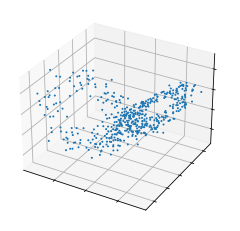

In [100]:
plotting.trajectories(X, style='o', lw=1, ms=1)

# Create random projections of state-space to scalar time series

In [103]:
from sklearn import random_projection
transformer = random_projection.SparseRandomProjection(n_components=1)

n_obs = 5

x = []
for i in range(n_obs):
    x_tmp = transformer.fit_transform(X)
    x_tmp = utils.standardise(x_tmp, norm='max')
    x.append(x_tmp)
    
x_stacked = np.hstack(x)
df = utils.to_pandas(x_stacked)

# Plot trajectories

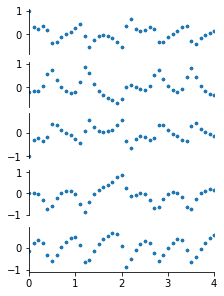

In [107]:
ax = plotting.time_series(T, x, style='.', figsize=(3,4), ms=5)
plt.xlim([0,4])
plt.savefig('../results/time_series.svg')

# Estimate system dimension

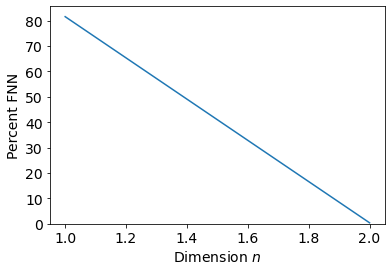

In [15]:
perc_FNN, E = FNN_n(x[:,0], 1, maxDim=10, plotting=True, Rtol=15, Atol=2, threshold=10)

# Find best multi-view embeddings

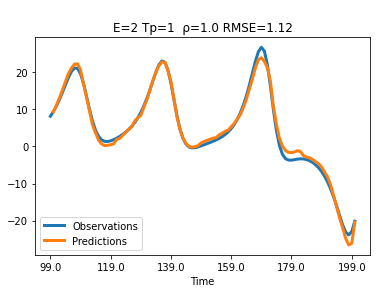

/var/folders/hj/113tdgn92h36jbyjj8hw4lkc0000gp/T/ipykernel_48981/2833718640.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  views = np.array(views, dtype=np.int)


In [16]:
#find best embedding views
columns = list(df.columns)[1:]
MVE = pyEDM.Multiview(dataFrame = df, 
                      lib = [1, 100], 
                      pred = [100, 200], 
                      E = E, 
                      D = E,
                      columns = columns, 
                      target = columns[0], 
                      showPlot = True)

views = MVE['View'].iloc[:,:E]
views = np.array(views, dtype=np.int)

#create embeddings
embedding = pyEDM.Embed(dataFrame = df, E = E, tau = -1, columns = columns)
embedding = np.array(embedding.dropna())
all_embeddings = np.stack([embedding[:,v-1] for v in views], axis=2)

# Create dataset

In [18]:
best_embedding = all_embeddings[0]

y = np.diff(best_embedding, axis=0)
pos = best_embedding[:-1]
k=10

#first create data with the best embedding to fit the graph
data = utils.construct_dataset(pos, y, graph_type='cknn', k=k)

#now all the other embeddings
y = [np.diff(emb, axis=0) for emb in all_embeddings]

#bring it to form [feature_1(x_1),...,feature_n(x_1),  feature_1(x_2),...,feature_n(x_2)]
y = np.stack(y, axis=2)
y = y.reshape(y.shape[0], -1)

data.x = utils.np2torch(y)
data.num_node_features = y.shape[1]

In [19]:
par = {'batch_size': 256, #batch size, this should be as large as possible
           'epochs': 30, #optimisation epochs
           'order': 2, #order of derivatives
           'depth': 0, #number of hops in neighbourhood
           'n_lin_layers': 2,
           'hidden_channels': 16, #number of internal dimensions in MLP
           'out_channels': 4,
           }

model = net(data, gauge='global', **par)
model.run_training(data)

/Users/gosztola/github/GeoDySys/GeoDySys/lib/utils.py:55: UserWarning: Sampled points (n_nb_samples) exceeds the degree (k)                      of the graph! Continuing with n_nb_samples=k... 
  warnings.warn('Sampled points (n_nb_samples) exceeds the degree (k)\


---- Settings: 

gauge : global
batch_size : 256
epochs : 30
order : 2
depth : 0
n_lin_layers : 2
hidden_channels : 16
out_channels : 4
local_gauge : False
seed : 0
lr : 0.01
dropout : 0.0
edge_dropout : 0.0
n_sampled_nb : 10
n_geodesic_nb : 50
vec_norm : False
b_norm : True
bias : False
large_scale : 4
n_scales : 4
signal_dim : 12
emb_dim : 2
vector : True
slices : tensor([  0, 998])


---- Number of features to pass to the MLP:  24
---- Total number of parameters:  721

---- Starting training ... 

Epoch: 1, Training loss: 5.4349, Validation loss: 11.0623
Epoch: 2, Training loss: 5.3817, Validation loss: 11.0616
Epoch: 3, Training loss: 5.1726, Validation loss: 11.0603
Epoch: 4, Training loss: 5.2048, Validation loss: 11.0574
Epoch: 5, Training loss: 5.4052, Validation loss: 11.0593
Epoch: 6, Training loss: 5.2415, Validation loss: 11.0517
Epoch: 7, Training loss: 5.0689, Validation loss: 11.0557
Epoch: 8, Training loss: 5.0351, Validation loss: 11.0539
Epoch: 9, Training loss: 5.059